In [25]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier   

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load data into a pandas DataFrame
train_data = pd.read_csv('training.csv', index_col='id')

# Drop the 'split' column, which has no impact on the event
train_data.drop(columns=['split'], inplace=True)

# Invert the event values to give more weight to the minority class
train_data['event'] = train_data['event'].replace({0: 1, 1: 0})

# drop rows with less than 3 non-null values
train_data = train_data.dropna(thresh=5)

# Extract the target column
train_target = train_data['event']

# Fill missing values with the mean
train_data.fillna(train_data.mean(), inplace=True)

#Prepare data use in ML algorithms
X = train_data.drop('event', axis=1).values
y = train_target.values

# Print out the percentage of samples that have the event
print('Default %:', train_target.sum() / train_target.shape[0] * 100)


Default %: 2.218265449959196


In [27]:
import pandas as pd
from sklearn import preprocessing

# Load test data into a pandas DataFrame
test_data = pd.read_csv('test.csv', index_col='id')

# Drop the 'split' column, which has no impact on the event
test_data.drop(columns=['split'], inplace=True)

# Invert the event values to give more weight to the minority class
test_data['event'] = test_data['event'].replace({0: 1, 1: 0})

# Extract the target column
test_target = test_data['event']

# Fill missing values with the mean from the training data
test_data.fillna(train_data.mean(), inplace=True)

X_test = test_data.drop('event', axis=1).values
y_test = test_target.values

# Print out the percentage of samples that have the event
print('Default %:', test_target.sum() / test_target.shape[0] * 100)


Default %: 2.5004605670836892


In [28]:
import scorecardpy as sc
print(pd.__version__)

# Create woebin bins
bins = sc.woebin(train_data, y ="event", num_breaks=5, min_perc_fine=0.05, min_perc_coarse=0.1)
                
# Concatenate the bins into a single DataFrame
bins_df = pd.concat([pd.DataFrame(bins[var]) for var in bins])

1.1.3
[INFO] creating woe binning ...


-------- 1/3 var2 --------
>>> dt[var2].describe(): 
count    6.739500e+04
mean     4.132497e+06
std      2.008377e+07
min      0.000000e+00
25%      1.201473e+05
50%      7.297099e+05
75%      2.791935e+06
max      1.590072e+09
Name: var2, dtype: float64 



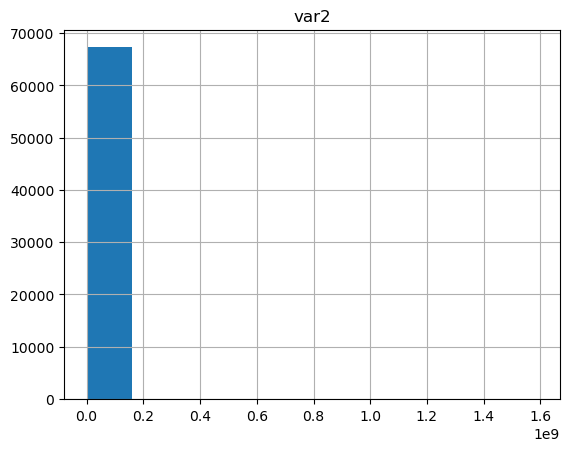

>>> Current breaks:
200000.0,1000000.0,4200000.0 



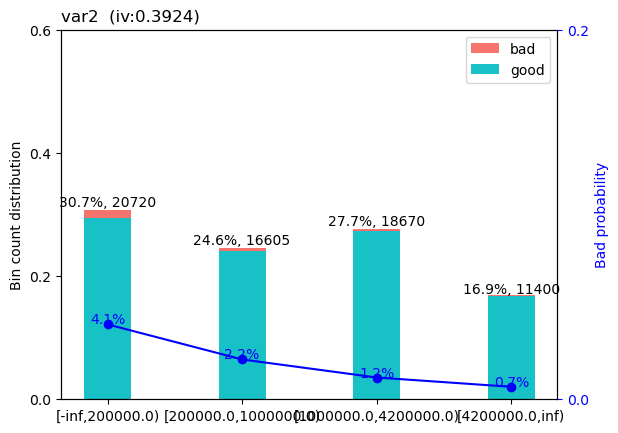

>>> Adjust breaks for (1/3) var2?
1: next 
2: yes 
3: back
Selection: 1
-------- 2/3 var3 --------
>>> dt[var3].describe(): 
count    67395.000000
mean        12.281068
std         71.144795
min          0.000000
25%          0.889729
50%          9.688440
75%         12.281068
max       9684.426685
Name: var3, dtype: float64 



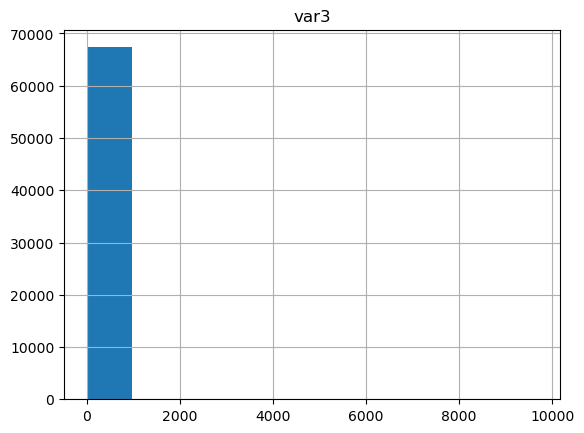

>>> Current breaks:
1.0,6.0,12.0,13.0 



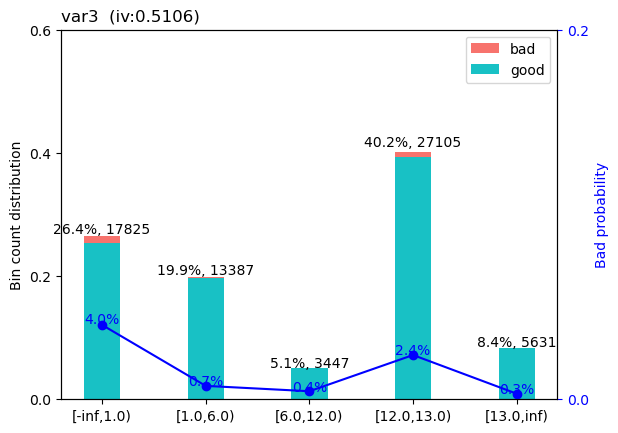

>>> Adjust breaks for (2/3) var3?
1: next 
2: yes 
3: back
Selection: 1
-------- 3/3 var7 --------
>>> dt[var7].describe(): 
count    67395.000000
mean        20.605911
std          3.853144
min          2.000000
25%         20.605911
50%         20.605911
75%         24.000000
max         24.000000
Name: var7, dtype: float64 



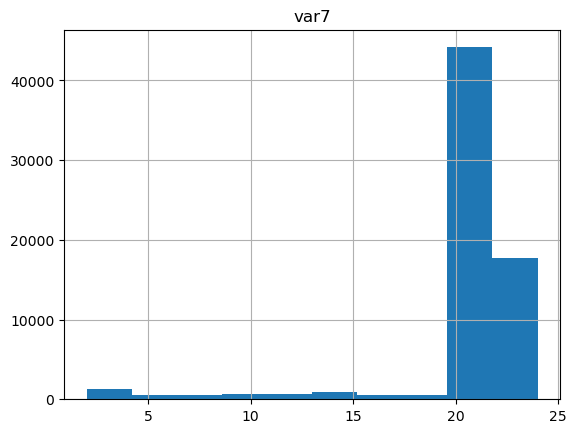

>>> Current breaks:
18.0,21.0 



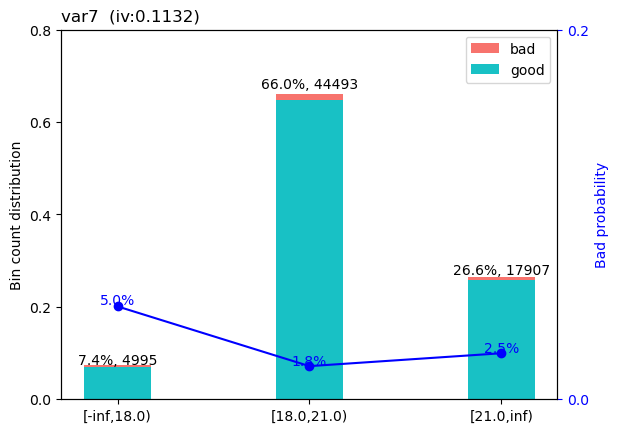

>>> Adjust breaks for (3/3) var7?
1: next 
2: yes 
3: back
Selection: 1
[INFO] creating woe binning ...


In [29]:
# binning adjustment - optimizing the binning results and improving the accuracy 
# adjust breaks interactively
breaks_adj = sc.woebin_adj(train_data, y="event", bins=bins) 
#or specify bin breaks manually
bins_adj = sc.woebin(train_data, y="event", breaks_list=breaks_adj)

Number of class 1 examples before: (1495, 8)
Number of class 1 examples after: (65900, 8)
(67395, 8)
(65900, 8)
(67395,)
(65900,)


(array([65900.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 65900.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

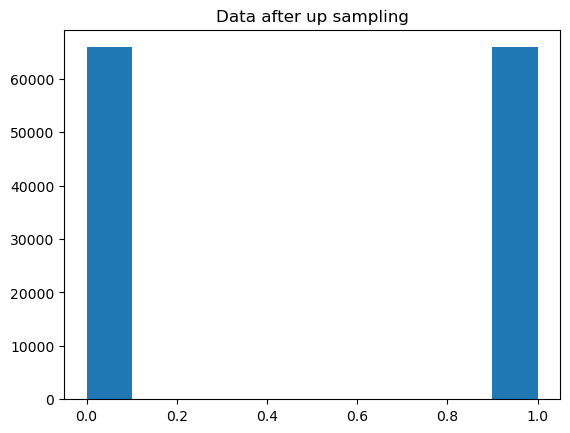

In [30]:
#Up-sampling - address class imbalance / prevent bias toward majority class
from sklearn.utils import resample



X_train=train_data.drop("event" ,axis= 1)
y_train=train_target

print('Number of class 1 examples before:', X_train[y_train == 1].shape)



X_upsampled, y_upsampled = resample(X_train[y_train == 1],
                                    y_train[y_train == 1],
                                    replace=True,
                                    n_samples=X_train[y_train == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X_upsampled.shape)
#print('Number of class 1 examples after:', y_upsampled.shape)

#UPSAMPLE


print(X_train.shape)
print(X_upsampled.shape)
print(y_train.shape)
print(y_upsampled.shape)

X_bal = np.vstack((X_train[y_train==0], X_upsampled))
y_bal = np.hstack((y_train[y_train==0], y_upsampled))

#check the data label balance
plt.title('Data after up sampling')
plt.hist(y_bal)

(131800, 8)
(59709, 8)
(131800,)
(59709,)


(array([65900.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 65900.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

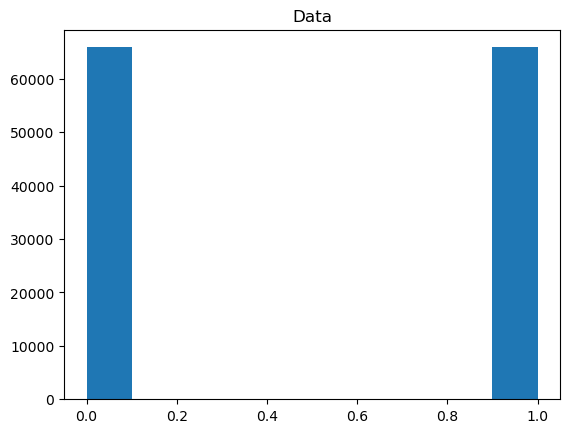

In [31]:
from sklearn.model_selection import train_test_split

X_train=X_bal
X_test
y_train=y_bal
y_test

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

plt.title('Data')
plt.hist(y_train)

In [32]:
X_train=pd.DataFrame(X_train,columns=train_data.columns[1:])

In [33]:
# converting train and test into woe values
train_woe = sc.woebin_ply(X_train, bins)
test_woe = sc.woebin_ply(pd.DataFrame(X_test, columns=X_train.columns), bins)

X_train = train_woe
X_test = pd.DataFrame(test_woe, columns=X_train.columns)




[INFO] converting into woe values ...
[INFO] converting into woe values ...


In [34]:
X_test

,var7_woe,var3_woe,var4_woe,var2_woe,var1_woe,var6_woe,var5_woe,var8_woe
0,-0.216868,0.613787,-0.840231,-1.204774,-0.397902,0.0,0.0,-0.466497
1,-0.216868,0.078207,1.718639,-0.643180,0.221256,0.0,0.0,0.217584
2,-0.216868,-1.646836,-0.840231,-1.204774,-0.397902,0.0,0.0,-0.964793
3,-0.216868,0.613787,-0.840231,-0.643180,-0.397902,0.0,0.0,-0.964793
4,-0.216868,0.078207,0.028805,-1.204774,-0.397902,0.0,0.0,-0.964793
...,...,...,...,...,...,...,...,...
59704,-0.216868,0.078207,0.028805,-0.643180,-0.397902,0.0,0.0,0.217584
59705,-0.216868,0.078207,0.028805,-0.643180,0.221256,0.0,0.0,0.217584
59706,-0.216868,0.078207,0.028805,-1.204774,-0.397902,0.0,0.0,0.217584
59707,-0.216868,0.078207,0.028805,-0.643180,0.221256,0.0,0.0,0.217584


In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Load data into a pandas DataFrame
train1_data = pd.read_csv('training.csv', index_col='id')

# Drop the 'split' column, which has no impact on the event
train1_data.drop(columns=['split'], inplace=True)

# Invert the event values to give more weight to the minority class
train1_data['event'] = train1_data['event'].replace({0: 1, 1: 0})

# drop rows with less than 3 non-null values
train1_data = train1_data.dropna(thresh=5)

# Extract the target column
train1_target = train1_data['event']

# Fill missing values with the mean
train1_data.fillna(train1_data.mean(), inplace=True)

X_train1 = train1_data.drop('event', axis=1).values
y_train1 = train1_target.values

In [36]:
# Load test data into a pandas DataFrame
test1_data = pd.read_csv('test.csv', index_col='id')

# Drop the 'split' column, which has no impact on the event
test1_data.drop(columns=['split'], inplace=True)

# Invert the event values to give more weight to the minority class
test1_data['event'] = test1_data['event'].replace({0: 1, 1: 0})

# Extract the target column
test1_target = test1_data['event']

# Fill missing values with the mean from the training data
test1_data.fillna(train1_data.mean(), inplace=True)

X_test1 = test1_data.drop('event', axis=1).values
y_test1 = test1_target.values


In [37]:
X_train1=pd.DataFrame(X_train1,columns=train1_data.columns[1:])
X_test1=pd.DataFrame(X_test1,columns=test1_data.columns[1:])

In [38]:
print(X_train1.shape)
print(X_test1.shape)

(67395, 8)
(59709, 8)


Number of class 1 examples before: (1495, 8)
Number of class 1 examples after: (65900, 8)
(67395, 8)
(65900, 8)
(67395,)
(65900,)


(array([65900.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 65900.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

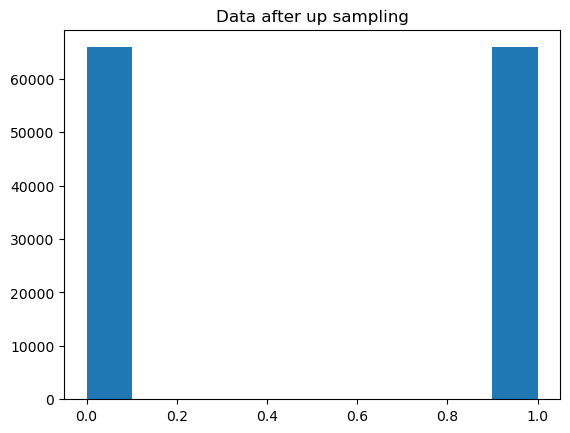

In [39]:
#Up-sampling - address class imbalance / prevent bias toward majority class
from sklearn.utils import resample



X_train1=train1_data.drop("event" ,axis= 1)
y_train1=train1_target

print('Number of class 1 examples before:', X_train1[y_train1 == 1].shape)



X1_upsampled, y1_upsampled = resample(X_train1[y_train1 == 1],
                                    y_train1[y_train1 == 1],
                                    replace=True,
                                    n_samples=X_train1[y_train1 == 0].shape[0],
                                    random_state=123)

print('Number of class 1 examples after:', X1_upsampled.shape)
#print('Number of class 1 examples after:', y_upsampled.shape)

#UPSAMPLE


print(X_train1.shape)
print(X1_upsampled.shape)
print(y_train1.shape)
print(y1_upsampled.shape)

X1_bal = np.vstack((X_train1[y_train1==0], X1_upsampled))
y1_bal = np.hstack((y_train1[y_train1==0], y1_upsampled))

#check the data label balance
plt.title('Data after up sampling')
plt.hist(y1_bal)

(131800, 8)
(59709, 8)
(131800,)
(59709,)


(array([65900.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0., 65900.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

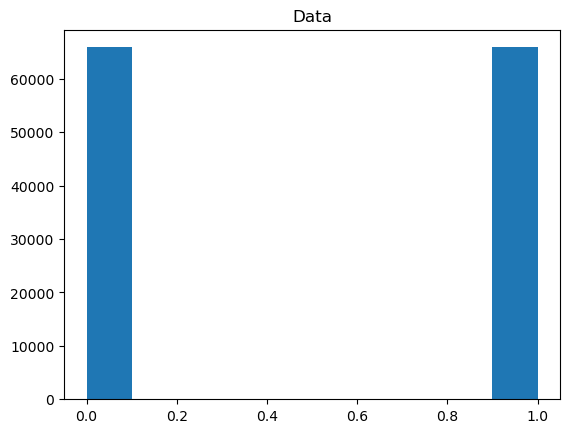

In [40]:
from sklearn.model_selection import train_test_split

X_train1=X1_bal
X_test1
y_train1=y1_bal
y_test1

print(X_train1.shape)
print(X_test1.shape)
print(y_train1.shape)
print(y_test1.shape)

plt.title('Data')
plt.hist(y_train1)

In [41]:
X_train1=pd.DataFrame(X_train1,columns=train1_data.columns[1:])

In [42]:
# add the original variables back into the train and test dataframes
X_train = pd.concat([X_train1.reset_index(drop=True), X_train.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test1.reset_index(drop=True), X_test.reset_index(drop=True)], axis=1)

# print the train and test dataframes
print('X_train:\n', X_train.head())
print('X_test:\n', X_test.head())


X_train:
    var1          var2       var3       var4        var5       var6       var7  \
0   2.0  7.522327e+06   1.163336  13.000000  213.620354  33.502923  20.605911   
1   1.0  5.661878e+05   0.646621  13.000000  213.620354  33.502923  20.605911   
2  13.0  8.810127e+03  12.281068  13.000000  213.620354  33.502923  24.000000   
3   1.0  1.194820e+06  12.281068  11.732548    4.893348   0.016672  20.605911   
4   1.0  8.041781e+05   4.453691  13.000000  213.620354  33.502923  24.000000   

        var8  var7_woe  var3_woe  var4_woe  var2_woe  var1_woe  var6_woe  \
0  45.375000 -0.216868 -1.134044 -0.840231 -1.204774  0.221256       0.0   
1  53.083333 -0.216868  0.613787 -0.840231 -0.029118 -0.397902       0.0   
2  58.250000  0.118606  0.078207 -0.840231  0.621945  1.187912       0.0   
3  68.500000 -0.216868  0.078207  0.028805 -0.643180 -0.397902       0.0   
4  71.333333  0.118606 -1.134044 -0.840231 -0.029118 -0.397902       0.0   

   var5_woe  var8_woe  
0       0.0  0.217584 

In [43]:
X_test = X_test[X_train.columns]

In [ ]:
from itertools import combinations
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def find_best_combination(X_train, X_test, y_train, y_test):
    best_accuracy = 0
    best_combination = []
    for i in range(1, len(X_train.columns)+1):
        for combination in combinations(X_train.columns, i):
            X_train_combination = X_train[list(combination)]
            X_test_combination = X_test[list(combination)]
            model = LogisticRegression(max_iter=1000, solver='liblinear')
            model.fit(X_train_combination, y_train)
            y_pred = model.predict(X_test_combination)
            accuracy = accuracy_score(y_test, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_combination = list(combination)
    return best_accuracy, best_combination

best_accuracy, best_combination = find_best_combination(X_train, X_test, y_train, y_test)
print("Best combination of variables:", best_combination)
print("Accuracy:", best_accuracy)
